In [14]:
suppressMessages(suppressWarnings({
    library(GSVA)
    library(msigdbr)
    library(data.table)
    library(ggplot2)
    library(cowplot)
    library(parallel)
    library(Rtsne)
    library(RColorBrewer)
    library(ggrastr)
}))
tic <- function() { startTime <<- Sys.time() }
toc <- function() { endTime <<- Sys.time(); cat(format(endTime-startTime),'\n') }
set_plot_size <- function(w, h) options(repr.plot.width = w, repr.plot.height = h)
set_plot_size_to_normal <- function() options(repr.plot.width = 8, repr.plot.height = 8)

# Figure 1B

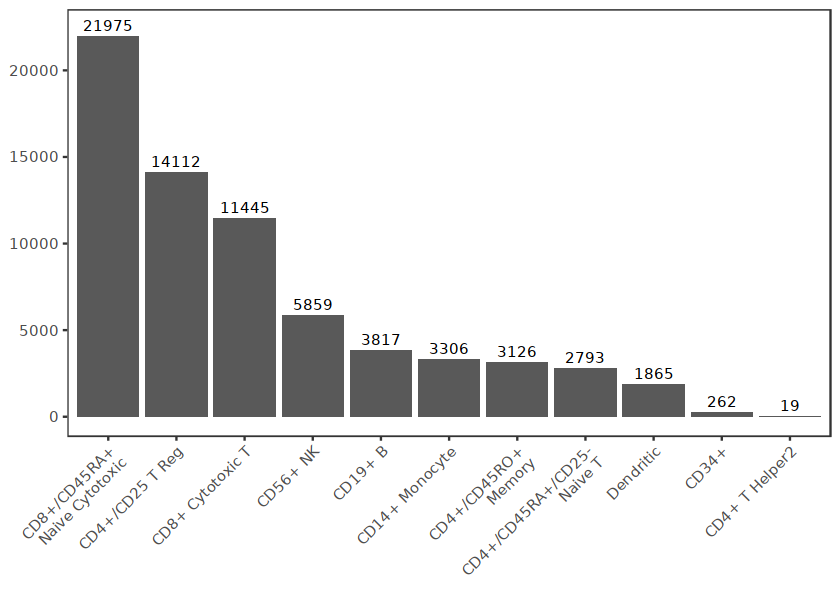

In [26]:
##########################################################################################
# plot the frequency of cell types in the whole dataset
##########################################################################################

load('/.mounts/labs/reimandlab/private/users/mslobodyanyuk/input_random_forest.Rdata', downstrean_data <- new.env())
cell_type_dt <- as.data.table(downstrean_data$tdf_n_1000)
stat <- as.data.table(sort(table(cell_type_dt$cls_id), decreasing = T))
stat[1]$V1 <- 'CD8+/CD45RA+\nNaive Cytotoxic'
stat[7]$V1 <- 'CD4+/CD45RO+\nMemory'
stat[8]$V1 <- 'CD4+/CD45RA+/CD25-\nNaive T'
stat$V1 <- factor(stat$V1, levels=stat$V1)

# pdf('stat.pdf', 7, 5)
set_plot_size(7,5)
ggplot(data=stat)+theme_bw()+
    geom_bar(stat='identity', aes(x=V1, y=N))+
    geom_text(aes(x = V1, y = N, label = N), hjust = 0.5, vjust=-0.5, size = 3,
              position = position_dodge(width = 1))+
    ylim(0, 1.02*max(stat$N))+
    theme(panel.grid = element_blank(), axis.text.x = element_text(angle=45, hjust=1), 
          axis.title = element_blank())
# dev.off()

# Figure 4 Gene set Variation Analysis and tSNE visualization

In [2]:
##############################################
# C7 biological processes from MSigDB
##############################################
C7 <- as.data.table(msigdbr(species = "Homo sapiens", category = "C7"))
gsdt <- C7[, list(gene = list(unique(human_ensembl_gene))), by='gs_id']
gs_C7 <- gsdt$gene
names(gs_C7) <- gsdt$gs_id

In [5]:
# load cell type annotation
load('/.mounts/labs/reimandlab/private/users/mslobodyanyuk/input_random_forest.Rdata', downstrean_data <- new.env())
cell_type_dt <- as.data.table(downstrean_data$tdf_n_1000)
cell_type_dt$sample_id <- paste0('s', 1:dim(cell_type_dt)[1])
# remove cell types with less than 1000 cells --> 
abundant_cell_types <- names(which(table(cell_type_dt$cls_id) > 1000))
rare_cell_types <- setdiff(cell_type_dt$cls_id, abundant_cell_types)
cell_type_dt <- cell_type_dt[cls_id %in% abundant_cell_types]
cell_type_dt$cls_id <- droplevels(cell_type_dt$cls_id)
# load expression matrix of 1000 most variable genes
m_n <- readRDS('processed data/m_n_1000.rds')
m_n <- Matrix::t(m_n)
colnames(m_n) <- paste0('s', 1:dim(m_n)[2])
m_n_s <- m_n[ , cell_type_dt$sample_id]

In [ ]:
#######################################################
# Calculate single-sample gene set enrichment scores
# *** Long process, takes several hours to complete
#######################################################
ES <- gsva(m_n_s, gs_C7, method='gsva' , min.sz=min.sz, max.sz=max.sz, verbose=TRUE)

In [ ]:
######################################################################################
# create feature matrix with cells in rows and gene set enrichment scores in columns.
# Last column will be for cell type
######################################################################################
feature_table <- cbind(t(dt), cell_type_dt[match(rownames(t(dt)), cell_type_dt$sample_id)][,c('sample_id','cls_id')])
stopifnot(identical(feature_table$sample_id, colnames(dt)) & identical(feature_table$sample_id, rownames(t(dt))))
feature_table <- feature_table[,-'sample_id']
colnames(feature_table) <- gsub(':','_',colnames(feature_table))
colnames(feature_table)[dim(feature_table)[2]] <- 'cell_type'

In [20]:
###################################################################
# tSNE plots of cells with gene set enrichment scores as features
###################################################################

set.seed(1)

# take randomly 10'000 cells to visualize using tSNE
dt_sub <- feature_table[sample(dim(feature_table)[1], 10000)]

# calculate tSNE mapping and plot
tsne <- Rtsne(dt_sub[,-'cell_type'], perplexity=30, check_duplicates = FALSE)
tsne_dt <- data.table(tSNE1 = tsne$Y[,1], tSNE2 = tsne$Y[,2])
tsne_dt$cell_type <- factor(dt_sub$cell_type)

mycols <- c(brewer.pal(n = 8, name = 'Set1'), 'black')

p1 <- ggplot()+theme_bw()+
    rasterise(geom_point(data=tsne_dt, aes(x=tSNE1, y=tSNE2, color = cell_type), size=0.5), dpi=300)+
    scale_color_manual(values = mycols)+
    guides(color = guide_legend(override.aes = list(size=5)))+
    theme(panel.grid = element_blank(), legend.title = element_blank())

p2 <- plot_grid(plotlist=lapply(1:length(levels(tsne_dt$cell_type)), function(i){
    this_cell_type <- levels(tsne_dt$cell_type)[i]
    ggplot()+theme_bw()+
        rasterise(geom_point(data=tsne_dt[cell_type != this_cell_type], aes(x=tSNE1, y=tSNE2), color = 'grey',size=0.5), dpi=300)+
        rasterise(geom_point(data=tsne_dt[cell_type == this_cell_type], aes(x=tSNE1, y=tSNE2), color = mycols[i],size=0.5), dpi=300)+
        ggtitle(this_cell_type)+
        theme(plot.title = element_text(hjust=0.5), panel.grid = element_blank(), legend.position='none')
}), nrow=3)

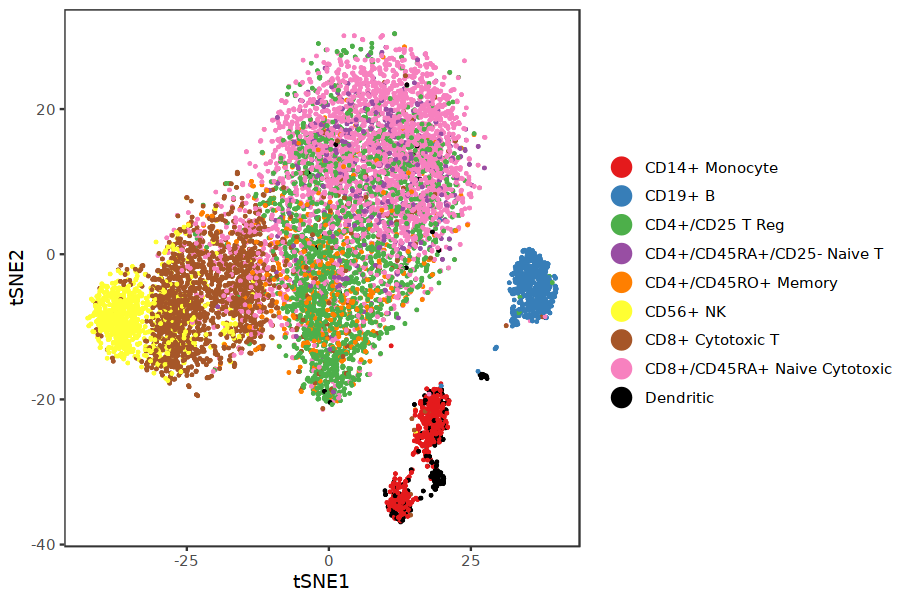

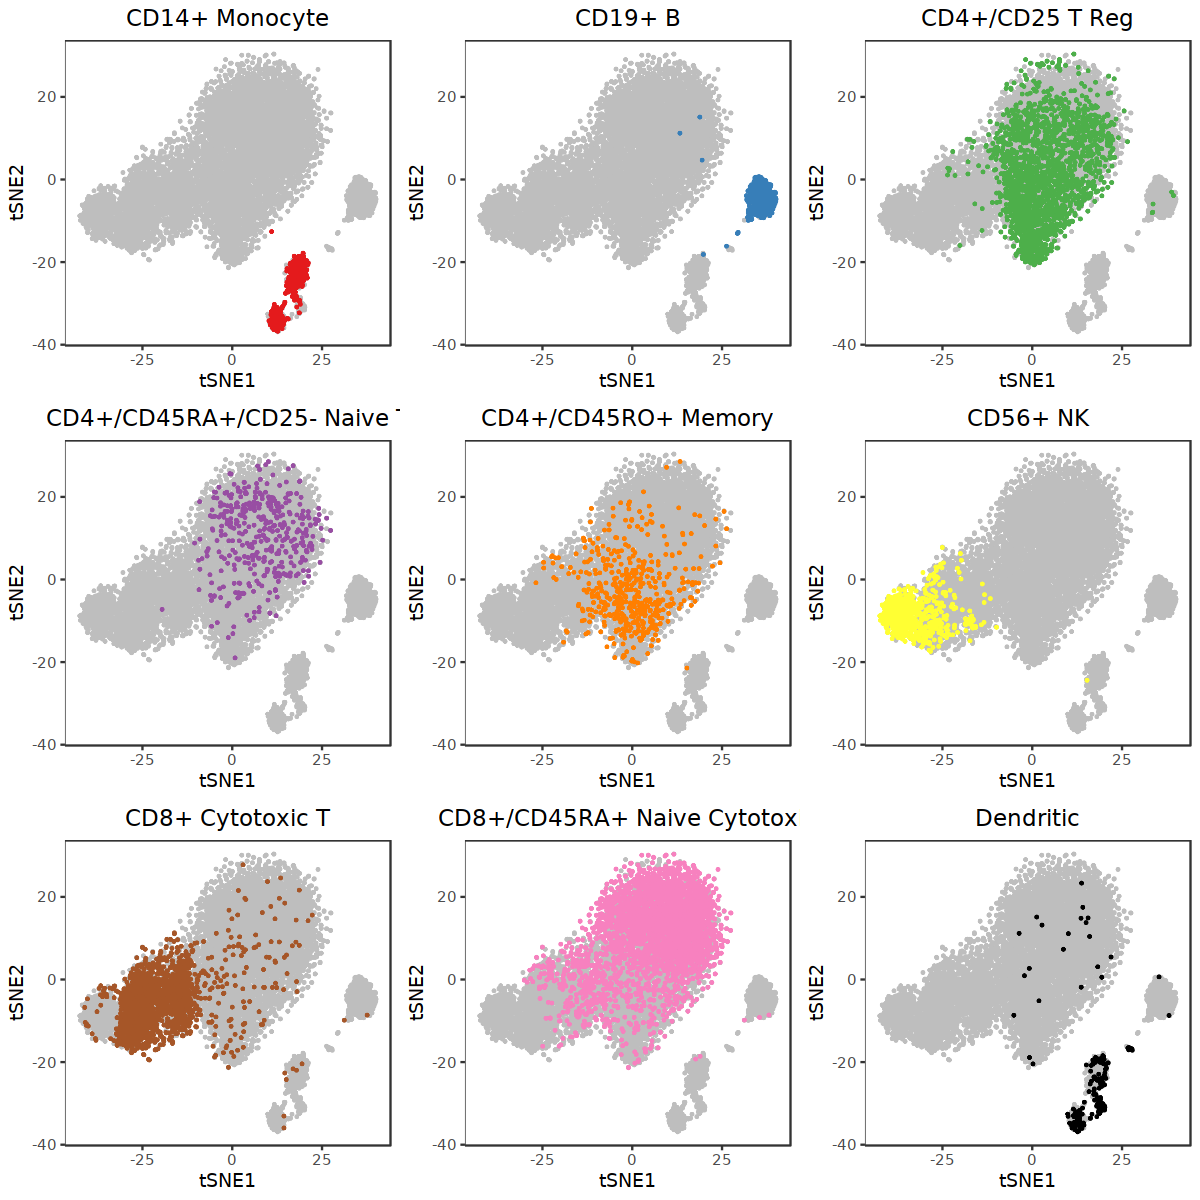

In [21]:
# pdf('tSNE1.pdf', 7.5, 5)
set_plot_size(7.5, 5)
plot(p1)
# dev.off()
# pdf('tSNE2.pdf', 10, 10)
set_plot_size(10,10)
plot(p2)
# dev.off()

# Figure 5A

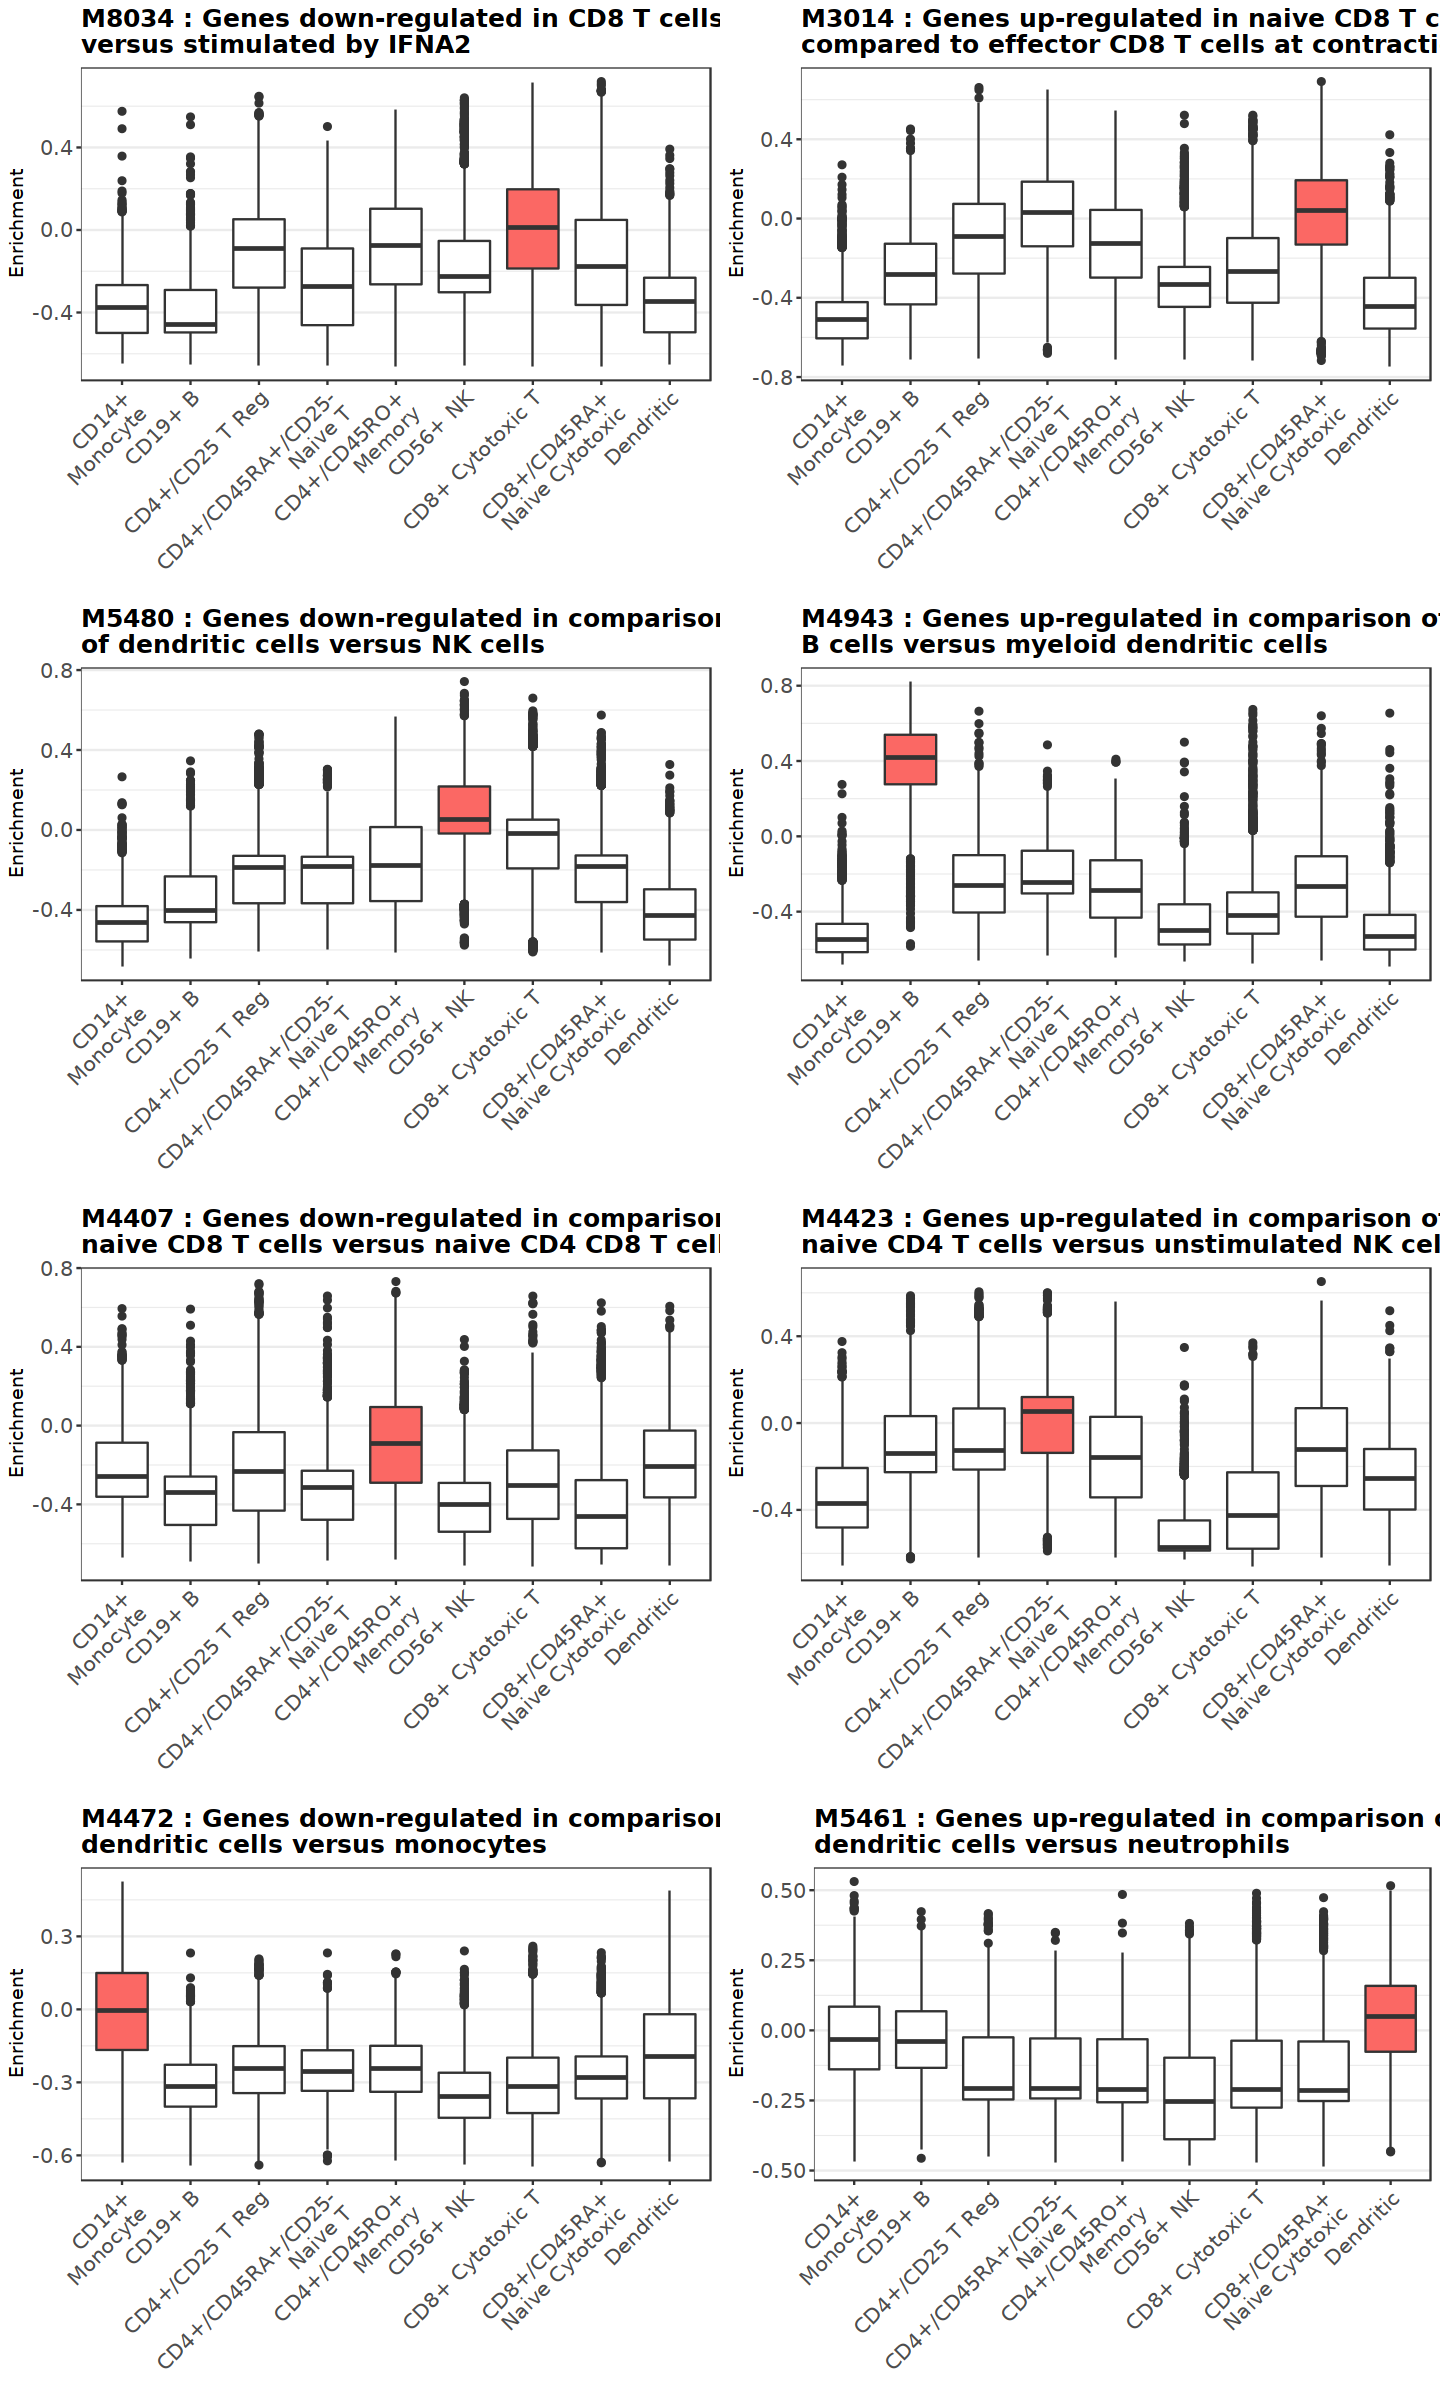

In [25]:
##########################################################################################
# plot the distributions of enrichment scores for specific gene sets across cell types
##########################################################################################

dt <- feature_table
x_axis_labels <-
     gsub('CD8\\+\\/CD45RA\\+ Naive Cytotoxic', 'CD8\\+\\/CD45RA\\+\nNaive Cytotoxic', 
          gsub('CD4\\+\\/CD45RO\\+ Memory', 'CD4\\+\\/CD45RO\\+\nMemory', 
               gsub('CD4\\+\\/CD45RA\\+\\/CD25- Naive T', 'CD4\\+\\/CD45RA\\+\\/CD25-\nNaive T', 
                    gsub('CD14\\+ Monocyte', 'CD14\\+\nMonocyte', levels(factor(dt$cell_type))))))


plot_enrich <- function(dt, this_cell_type, this_gs, this_gs_desc, title_sz=14.4, axis_sz=12){
    this_dt <- dt[,c(this_gs,'cell_type'),with=F]
    this_dt$fill <- this_dt[['cell_type']] == this_cell_type
    ggplot()+theme_bw()+
        geom_boxplot(data=this_dt, aes_string(x='cell_type', y=this_gs, fill='fill'))+
        scale_fill_manual(values = c('TRUE'='#FB6864', 'FALSE'='white'))+
        scale_x_discrete(labels = x_axis_labels)+
        ylab('Enrichment')+
        ggtitle(paste0(this_gs,' : ',this_gs_desc))+
        theme(panel.grid.major.x = element_blank(),
              plot.title = element_text(face = 'bold', size=title_sz), 
              axis.text.y = element_text(size=axis_sz),
              axis.text.x = element_text(angle = 45, hjust=1, size=axis_sz), 
              axis.title.x = element_blank(), legend.position = 'none')
}
# pdf('diff_enriched_gene_sets.pdf', width=12, height=20)

set_plot_size(12, 20)

plot_grid(
    plot_grid(plot_enrich(dt, 'CD8+ Cytotoxic T', 'M8034', 
                          'Genes down-regulated in CD8 T cells: control\nversus stimulated by IFNA2'),
              
              plot_enrich(dt, 'CD8+/CD45RA+ Naive Cytotoxic', 'M3014', 
                          'Genes up-regulated in naive CD8 T cells\ncompared to effector CD8 T cells at contraction phase'),
              nrow = 1),
    
    plot_grid(plot_enrich(dt, 'CD56+ NK', 'M5480', 
                          'Genes down-regulated in comparison\nof dendritic cells versus NK cells'),
              
              plot_enrich(dt, 'CD19+ B', 'M4943', 
                          'Genes up-regulated in comparison of\nB cells versus myeloid dendritic cells'),
              nrow = 1),
    
    plot_grid(plot_enrich(dt, 'CD4+/CD45RO+ Memory', 'M4407', 
                          'Genes down-regulated in comparison of\nnaive CD8 T cells versus naive CD4 CD8 T cells'),
              
              plot_enrich(dt, 'CD4+/CD45RA+/CD25- Naive T', 'M4423', 
                          'Genes up-regulated in comparison of\nnaive CD4 T cells versus unstimulated NK cells'),
              nrow = 1),
    
    plot_grid(plot_enrich(dt, 'CD14+ Monocyte', 'M4472', 
                          'Genes down-regulated in comparison of\ndendritic cells versus monocytes'),
              
              plot_enrich(dt, 'Dendritic', 'M5461', 
                          'Genes up-regulated in comparison of\ndendritic cells versus neutrophils'),
              nrow = 1),
    
    ncol = 1)

# dev.off()